# Bird or Forest Classification Using Resnet-18 Model

#### Main task: Classify images into two categories: **birds** and **forests**.

1. Download Images - a set of images belonging to two categories: birds and forests.
2. Use Torch Transforms and Torchvision Dataloader - efficient data loading and augmentation
3. Load ResNet-18 Model - pre-trained on the ImageNet dataset.
4. Alter ResNet-18 Model Architecture - to fit our specific task
5. Fine-Tune ResNet-18 Model - training some model layers on our dataset

### ResNet (Residual Network) Models

- Ever since the first CNN-based model, image classification has increasingly useed more layers in deep neural networks

- Usually, adding more layers is beneficial, but beyond a certain point, it triggers a common deep learning problem known as the vanishing gradients. 

- As the gradient values are passed through many layers, they can get smaller and smaller, essentially "vanishing" to zero. This makes it very difficult to update the weights in the earlier layers of the network, leading to very slow or stagnant training progress, particularly in networks with many layers.

- Residual Connection: In order to solve the problem of the vanishing gradient, this architecture introduced the concept called **skip connections**. The skip connection connects activations of a  layer to further layers by skipping some layers in between. These connections make it easier for gradients to flow back through the network during training, ensuring that even the early layers get updated effectively. This results in faster convergence and often better overall performance.

<img src="assets/skip_connection.png" alt="Plain vs ResNet" style="max-height: 300px;">
<img src="assets/normal_resnet.png" alt="Plain vs ResNet" style="max-height: 300px;">


- This residual connection enables ResNet networks to be significantly deeper (e.g., 18, 32, ..., 152 ) without performance degradation

## Step 0: Download dataset

We will utilize libraries:
- **fast.ai** - image download and verification [https://github.com/fastai/fastai](https://github.com/fastai/fastai)
- **dudduckgo_search** for web scraping for imgaes [https://github.com/deedy5/duckduckgo_search](https://github.com/deedy5/duckduckgo_search)

In [ ]:
!pip install -q duckduckgo_search fastai

In [2]:
from time import sleep
from pathlib import Path

from fastai.vision.all import download_images, resize_images, verify_images, get_image_files
from duckduckgo_search import DDGS

DATASET_PATH = 'bird_or_not'

In [ ]:
def search_images(term, max_images=5):
    """
    Search DuckDuckGo Engine to find images by `term` and return their urls (number of limited by `max_images`).
    """
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(term)
        count = 0
        ddgs_images_list = []
        while count < max_images:
            image = ddgs_images_gen[count]
            # get image url
            url = image.get('image')
            # if url containts arguments, remove them
            i = url.find("?")
            if i > 0:
                url = url[:i]
            ddgs_images_list.append(url)
            count = count+1
        return ddgs_images_list

In [ ]:
urls = search_images('bird photos', max_images=5)
for url in urls:
    print(url)

In [ ]:
urls = search_images('forest photos', max_images=5)
for url in urls:
    print(url)

### In the next step download images to train-test-validation split

1. search for different images of forest and birds
2. save images to different folders
3. resize images to max_size

*NOTE: Pause between searches to prevent crashing*

In [ ]:
searches = ['forest', 'bird']
# Pause between searches to avoid over-loading server
TIME_SLEEP = 0.5


# Training
save_dir = Path(DATASET_PATH) / "train"
nr_images = 25
for search_term in searches:
    dest = save_dir / search_term
    dest.mkdir(exist_ok=True, parents=True)

    # download 1
    term = f'{search_term} photo'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)
    
    # download 2
    term = f'{search_term} sun photo'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)

    # donwload 3
    term = f'{search_term} shade photo'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)

    # resize
    resize_images(dest, max_size=400, dest=dest)


# Validation
save_dir = Path(DATASET_PATH) / "val"
nr_images = 5
for search_term in searches:
    dest = save_dir / search_term
    dest.mkdir(exist_ok=True, parents=True)

    # download 1
    term = f'{search_term} photography'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)
    
    # download 2
    term = f'{search_term} sun photography'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)

    # donwload 3
    term = f'{search_term} shade photography'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)

    # resize
    resize_images(dest, max_size=400, dest=dest)


# Test
save_dir = Path(DATASET_PATH) / "test"
nr_images = 10
for search_term in searches:
    dest = save_dir / search_term
    dest.mkdir(exist_ok=True, parents=True)

    # download 1
    term = f'{search_term} image'
    download_images(dest, urls=search_images(term, max_images=nr_images))
    print("Downloaded", term)
    sleep(TIME_SLEEP)

    # resize
    resize_images(dest, max_size=400, dest=dest)


In [ ]:
# Verify images (check whether can be loaded)

path = Path(DATASET_PATH)
failed = verify_images(get_image_files(path))
for fail in failed:
    print("could not open:", fail)
failed.map(Path.unlink)
print("Failed images:", len(failed))

## Step 1: Load and Augment Dataset

We will utilize libraries:
- **Torchvision** - to transform or augment data [https://pytorch.org/vision/stable/transforms.html](https://pytorch.org/vision/stable/transforms.html)

### Image Folder

```bash
- train/bird/xxx.png
- train/bird/yyy.png
- train/forest/xxx.png
- train/forest/yyy.png
```

In [4]:
from pathlib import Path
from torchvision.datasets import ImageFolder

train_path = Path(DATASET_PATH) / "train"

train_folder = ImageFolder(train_path)
print(train_folder)

Dataset ImageFolder
    Number of datapoints: 144
    Root location: bird_or_not/train


In [7]:
print("Classes:", train_folder.classes)
print("Classes:", train_folder.class_to_idx)

Classes: ['bird', 'forest']
Classes: {'bird': 0, 'forest': 1}


In [8]:
for img in train_folder.imgs[69:80]:
    print(img)

('bird_or_not/train/bird/fad65dc1-1a2e-482a-a012-b8e2a4426273.jpg', 0)
('bird_or_not/train/bird/fc0efa03-6119-466b-b5e5-ecb2d8517557.jpg', 0)
('bird_or_not/train/bird/fd4a0a74-6300-4d0b-9ba6-4c9264931e58.jpg', 0)
('bird_or_not/train/bird/ff1b5bb2-99bb-4459-a120-d463fa649158.jpg', 0)
('bird_or_not/train/bird/ffc5d528-6268-4429-a5bd-ea523a445778.jpg', 0)
('bird_or_not/train/forest/0adcb7aa-64a3-4ffd-a083-a23734694a54.jpg', 1)
('bird_or_not/train/forest/0dc1ad92-7af1-4e9e-b5f0-617559214203.jpeg', 1)
('bird_or_not/train/forest/0dc368f8-adcd-4b73-896e-3a973a7233c1.jpeg', 1)
('bird_or_not/train/forest/0ead1bf5-a620-44e8-8d87-9e1253d1d053.jpeg', 1)
('bird_or_not/train/forest/11bc5c2e-08b2-46dc-9c0f-8f0214bdad74.png', 1)
('bird_or_not/train/forest/18a6d050-0507-4580-8cf9-df795fcaeb96.jpg', 1)


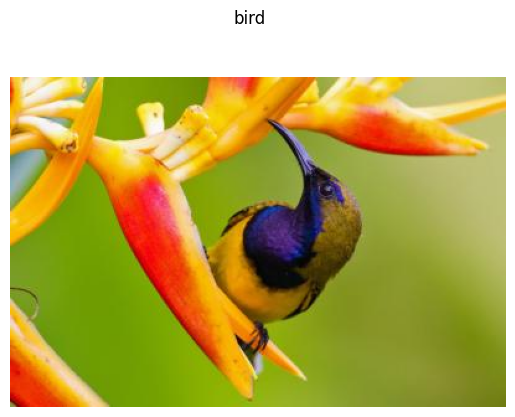

In [11]:
from PIL import Image
from matplotlib import pyplot as plt

img_path, img_class = train_folder.imgs[12]

image = Image.open(img_path)

plt.suptitle(train_folder.classes[img_class])
plt.imshow(image)
plt.axis('off')
plt.show()

### Transforms

- loading
- augmentation
- chained together using Compose `transforms.Compose`
- accepts PIL Image, Tensor Image or batch of Tensor Images as input

Note:
- Tensor Image Shape: `C x H x W`
- Tensor Batch Shape: `B x C x H x W`

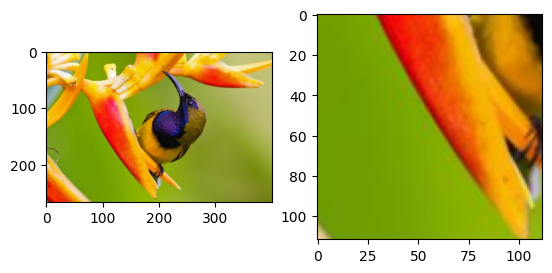

In [17]:
from torchvision.transforms import transforms


# TODO: on the fly
# Try Flip, Rotate, Padding, Crop, ResizeCrop, RandomPerspective, ColorJitter

transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.RandomResizedCrop(112),
    # transforms.CenterCrop(224),
    # transforms.Pad(padding=50),
    # transforms.RandomRotation(120),
    # transforms.RandomVerticalFlip(0.5),
    # transforms.ColorJitter(brightness=0.1, contrast=0.5, saturation=0.3, hue=0.4),
    # transforms.ColorJitter(contrast=(0, 10)),
    # transforms.RandomSolarize(threshold=5.0)
])

transformed_image = transform(image)


fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(transformed_image)
plt.show()

In [18]:
# Define the transformations to apply to the images during training

# Note: Normalize is done by calculating the mean and standard deviation of your dataset images and making your data unit normed.
# But, to simplify, just use imagenet dataset's mean and standard deviation to normalize the dataset approximately.
# These numbers are imagenet mean and standard deviation!

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

1. Use Transforms in ImageFolder
2. Use ImageFolder in Dataloder

In [21]:
from torch.utils.data import DataLoader

# TODO: on the fly

train_path = Path(DATASET_PATH) / "train"
val_path = Path(DATASET_PATH) / "val"

# 1
train_folder = ImageFolder(train_path, transform=train_transform)
val_folder = ImageFolder(val_path, transform=val_transform)

# 2
train_dataset = DataLoader(train_folder, batch_size=4, shuffle=True)
val_dataset = DataLoader(val_folder, batch_size=4, shuffle=False)

2
torch.Size([4, 3, 224, 224]) torch.Size([4])
(3, 224, 224)
(224, 224, 3)


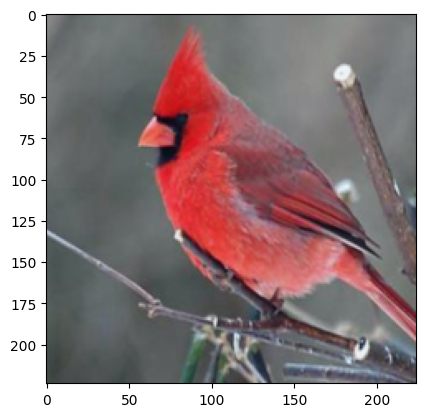

In [20]:
import numpy as np

iterator = iter(train_dataset)
batch = next(iterator)

print(len(batch))
print(batch[0].shape, batch[1].shape)
# [0] -> image (Tensor)
# [1] -> class (Bird / Forest)


# TODO: on the fly
array = batch[0][0].numpy()
print(array.shape)
array = np.transpose(array, [1, 2, 0])
print(array.shape)

array = (array - array.min()) / (array.max() - array.min())
plt.imshow(array)
plt.show()

## Step 2: ResNet-18

In [22]:
import torchvision.models as models

model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/opt/homebrew/Caskroom/miniforge/base/envs/mlworkshop/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlworkshop/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
print("Number of output layers:", model.fc.out_features)

Number of output layers: 1000


Modify ResNet model output layer

In [24]:
import torch

# TODO: on the fly

num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [25]:
print("Number of output layers:", model.fc.out_features)

Number of output layers: 2


## Step 3: Test ResNnet on test 'bird/forest' dataset

We will test the model performance on test dataset before fine-tunning

In [26]:
# Helper Scripts
import torchvision.transforms.functional as F

def unnormalize(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return img


def display_images(images, true_labels, predicted_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        img = unnormalize(images[i])
        img = F.to_pil_image(img)
        ax.imshow(img)
        ax.set_title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}', color=("green" if true_labels[i] == predicted_labels[i] else "red"))
    plt.show()

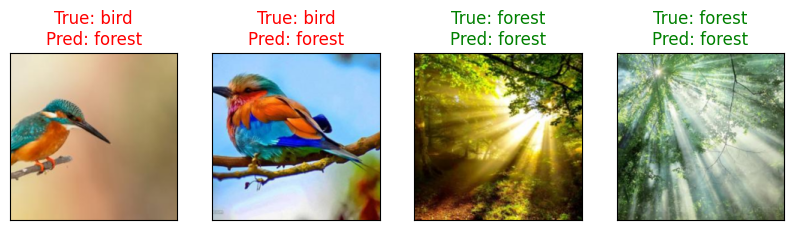

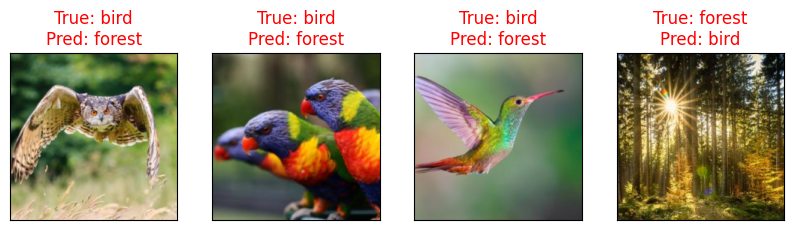

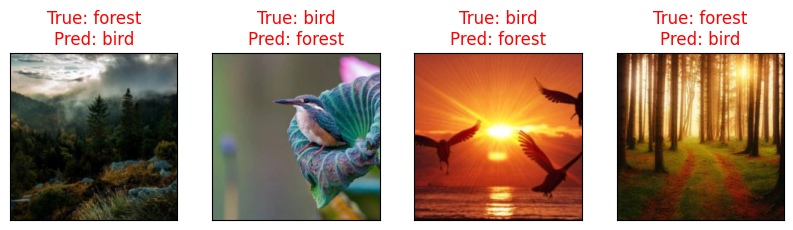

In [27]:
# use validation transforms
test_path = Path(DATASET_PATH) / "test"
test_folder = ImageFolder(val_path, transform=val_transform)
test_dataset = DataLoader(test_folder, batch_size=4, shuffle=True)

model.eval()
with torch.no_grad():
    count = 0
    for inputs, classes in test_dataset:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        display_images(inputs, classes, preds, test_folder.classes)
        if count >= 2:
            break
        count += 1

## Step 4: Train ResNet

1. Train Last Layer (FC)
    - larger learning rate
2. Fine-Tune ResNet
    - smaller learning rate

In [28]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Train step that takes model, training and validation dataloaders, loss functions, optimizer, number of epochs and device
    """
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)

        # Print the epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')



### 4.1: Fine-tune the last layer for a few epochs

Freeze all layers except FC

In [29]:
for parameter in model.parameters():
    parameter.requires_grad = False

for parameter in model.fc.parameters():
    parameter.requires_grad = True

for parameter_name, parameter_value  in model.named_parameters():
    print(parameter_value.requires_grad, parameter_name)

False conv1.weight
False bn1.weight
False bn1.bias
False layer1.0.conv1.weight
False layer1.0.bn1.weight
False layer1.0.bn1.bias
False layer1.0.conv2.weight
False layer1.0.bn2.weight
False layer1.0.bn2.bias
False layer1.1.conv1.weight
False layer1.1.bn1.weight
False layer1.1.bn1.bias
False layer1.1.conv2.weight
False layer1.1.bn2.weight
False layer1.1.bn2.bias
False layer2.0.conv1.weight
False layer2.0.bn1.weight
False layer2.0.bn1.bias
False layer2.0.conv2.weight
False layer2.0.bn2.weight
False layer2.0.bn2.bias
False layer2.0.downsample.0.weight
False layer2.0.downsample.1.weight
False layer2.0.downsample.1.bias
False layer2.1.conv1.weight
False layer2.1.bn1.weight
False layer2.1.bn1.bias
False layer2.1.conv2.weight
False layer2.1.bn2.weight
False layer2.1.bn2.bias
False layer3.0.conv1.weight
False layer3.0.bn1.weight
False layer3.0.bn1.bias
False layer3.0.conv2.weight
False layer3.0.bn2.weight
False layer3.0.bn2.bias
False layer3.0.downsample.0.weight
False layer3.0.downsample.1.wei

In [31]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)
train(model, train_dataset, val_dataset, loss_function, optimizer, num_epochs=20, device=device)

Epoch [1/20], train loss: 12.1907, train acc: 3.3056, val loss: 0.0222, val acc: 3.6250
Epoch [2/20], train loss: 6.7377, train acc: 3.5556, val loss: 0.0000, val acc: 3.6250
Epoch [3/20], train loss: 13.7955, train acc: 3.1111, val loss: 0.0000, val acc: 3.6250
Epoch [4/20], train loss: 18.4221, train acc: 2.9722, val loss: 0.0000, val acc: 3.6250
Epoch [5/20], train loss: 6.5413, train acc: 3.5278, val loss: 0.0000, val acc: 3.6250
Epoch [6/20], train loss: 4.4668, train acc: 3.7500, val loss: 0.6337, val acc: 3.5000
Epoch [7/20], train loss: 14.0368, train acc: 3.3056, val loss: 0.0000, val acc: 3.6250
Epoch [8/20], train loss: 5.8168, train acc: 3.5833, val loss: 0.0000, val acc: 3.6250
Epoch [9/20], train loss: 5.5877, train acc: 3.5556, val loss: 0.0000, val acc: 3.6250
Epoch [10/20], train loss: 6.9265, train acc: 3.5278, val loss: 0.0000, val acc: 3.6250
Epoch [11/20], train loss: 13.5043, train acc: 3.2500, val loss: 0.0000, val acc: 3.6250
Epoch [12/20], train loss: 10.4277, 

### 4.2: Fine-tune the entire model for a few epochs

Unfreeze all the layers

In [32]:
for param in model.parameters():
    param.requires_grad = True

In [35]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
train(model, train_dataset, val_dataset, loss_function, optimizer, num_epochs=10, device=device)

Epoch [1/10], train loss: 3.8575, train acc: 2.6389, val loss: 5.7066, val acc: 2.3750
Epoch [2/10], train loss: 2.8187, train acc: 3.1944, val loss: 6.0952, val acc: 2.7500
Epoch [3/10], train loss: 4.3330, train acc: 2.5556, val loss: 2.7673, val acc: 2.6250
Epoch [4/10], train loss: 3.3142, train acc: 2.8056, val loss: 1.0303, val acc: 3.2500
Epoch [5/10], train loss: 2.4113, train acc: 3.0556, val loss: 6.9553, val acc: 3.1250
Epoch [6/10], train loss: 2.3961, train acc: 3.0278, val loss: 1.2809, val acc: 3.1250
Epoch [7/10], train loss: 2.3436, train acc: 3.0833, val loss: 0.8613, val acc: 3.2500
Epoch [8/10], train loss: 4.1011, train acc: 2.8056, val loss: 7.1168, val acc: 3.1250
Epoch [9/10], train loss: 1.4536, train acc: 3.3333, val loss: 0.7887, val acc: 3.2500
Epoch [10/10], train loss: 2.7506, train acc: 3.1111, val loss: 0.8183, val acc: 3.3750


## Step 5: Test ResNnet on test 'bird/forest' dataset

We will test the model performance on test dataset **after** fine-tunning

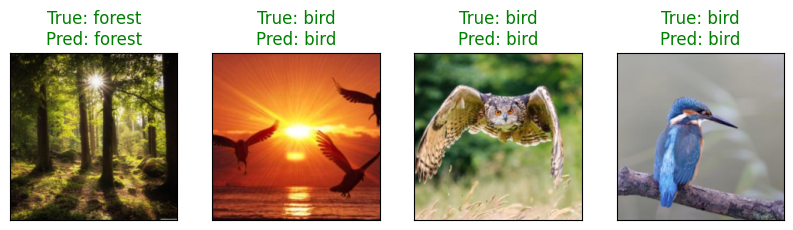

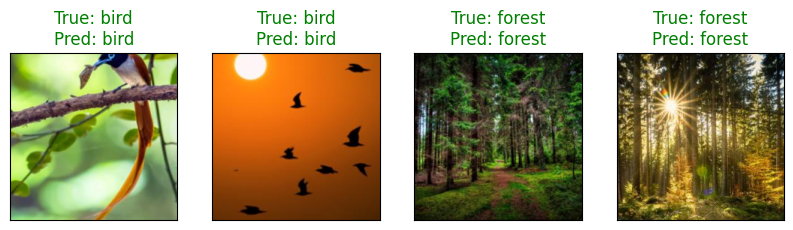

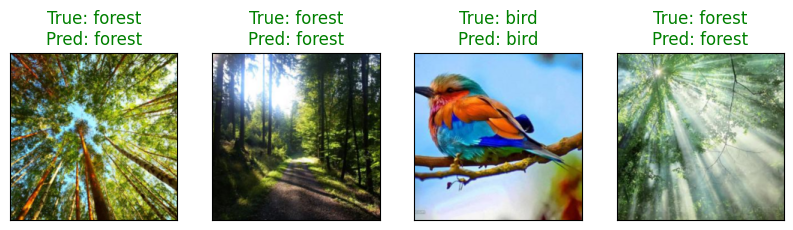

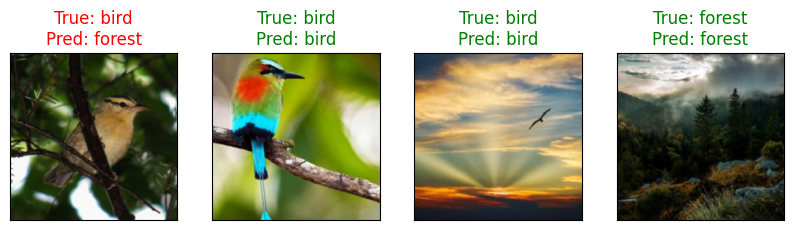

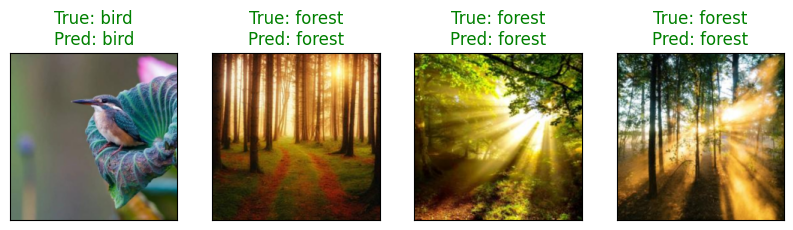

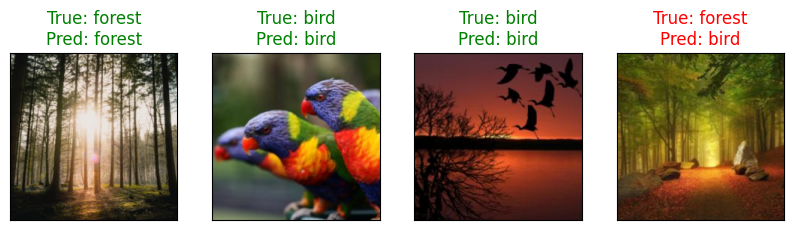

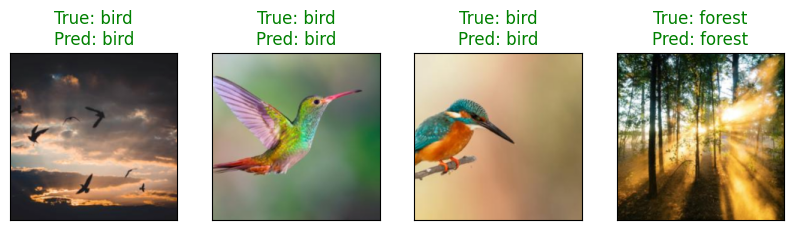

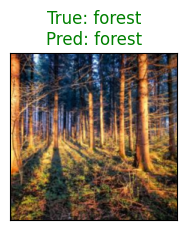

In [36]:
# use validation transforms
model.eval()
with torch.no_grad():
    count = 0
    for inputs, classes in test_dataset:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        display_images(inputs, classes, preds, test_folder.classes)
        if count >= 20:
            break
        count += 1